# Create MBTiles for Soils-revealed platform

Check this [notebook](https://github.com/Vizzuality/sci_team_data_bank/blob/master/Encyclopedia/map_tile_processing/MBTiles_from_Carto_data.ipynb) for further information on the creation of `MBTiles`.

## Table of Contents
### [Python libraries](#libraries)
### [Utils](#utils)
- **[df_from_carto](#df_from_carto)**
- **[long_lasting_SQL_queries](#long_lasting_SQL_queries)**
- **[create_mbtiles](#create_mbtiles)**

### [Read data from different sources ](#read_data)
- **[Biomes](#biomes)**
- **[World Database on Protected Areas](#protected_areas)**
- **[River basins](#river_basins)**
- **[Political boundaries](#political_boundaries)**

### [Create `MBTiles`](#create_mbtiles_2)
### [Show `MBTiles` in our localhost](#show_mbtiles)

<a id='libraries'></a>
### Python libraries

In [1]:
import os
import requests
import pandas as pd
import geopandas as gpd
import shapely.wkb 
from shapely.ops import cascaded_union
from carto.auth import APIKeyAuthClient
from carto.sql import BatchSQLClient
from carto.sql import SQLClient
from tqdm import tqdm
import getpass
import subprocess
import time
import LMIPy

<a id='utils'></a>
### Utils
<a id='df_from_carto'></a>
**df_from_carto**

In [2]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

<a id='long_lasting_SQL_queries'></a>
**long_lasting_SQL_queries**

In [3]:
def long_lasting_SQL_queries(account, query, api_key):
    # For long lasting SQL queries we use the batch SQL API.
    table_name = 'job_result'
    
    base_url = f'https://{account}.carto.com/'
    auth_client = APIKeyAuthClient(api_key=api_key, base_url=base_url)
    
    sql_query =(f'SELECT * INTO {table_name} FROM ({query}) as job')
    
    LIST_OF_SQL_QUERIES = [sql_query]
    
    batchSQLClient = BatchSQLClient(auth_client)
    createJob = batchSQLClient.create(LIST_OF_SQL_QUERIES)
    
    # Check the status of a job with the job_id every 10 s
    readJob = batchSQLClient.read(createJob['job_id'])
    
    timeout = time.time() + 60*60  # 1 hour from now
    while readJob.get('status') != 'done':
        time.sleep(10)
        print(readJob.get('status'))
        if readJob.get('status') == 'failed':
            print('Job failed.')
            break
        if time.time() > timeout:
            readJob = batchSQLClient.read(createJob['job_id'])
            # Cancel a job given its job_id
            if readJob.get('status') != 'donne':
                cancelJob = batchSQLClient.cancel(createJob['job_id'])     
                print('Job cancelled after 1 hour running')
                break
            
        readJob = batchSQLClient.read(createJob['job_id'])
       
    # Read the table
    sql = SQLClient(auth_client)
    data = sql.send("select * from "+table_name)
    
    # Drop the table
    sql = SQLClient(auth_client)
    sql.send("DROP TABLE "+table_name)
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

<a id='create_mbtiles'></a>
**create_mbtiles**

In [4]:
def create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel"):
    """
    Use tippecanoe to create a MBTILE at dest_path from source_path.
    layer_name is used for the name of the layer in the MBTILE.
    Regex file path (/*.geojson) is supported for source_path.
    """
    cmd = f"tippecanoe -o {dest_path} -l {layer_name} {opts} {source_path}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
    print("Finished processing")

<a id='read_data'></a>
### Read data from different sources 

<a id='biomes'></a>
#### **[Biomes](https://resourcewatch.org/data/explore/bio042-Ecoregion-by-Biome)**

In [ ]:
ds = LMIPy.Dataset('ed1544bb-a092-424e-88c2-8d548f4ef94a')
ds

In [ ]:
biomes = gpd.read_file('../data/mbtiles/bio_042_ecoregions_by_biome_1_14/bio_042_ecoregions_by_biome_1_14.shp')
biomes.drop(columns='cartodb_id', inplace=True)
biomes.head()

In [ ]:
biomes.plot()

Save `GeoDataFrame` as `GeoJSON`

In [ ]:
biomes.to_file("../data/mbtiles/ecoregions_by_biome.json", driver="GeoJSON")

<a id='protected_areas'></a>
#### **[World Database on Protected Areas](https://resourcewatch.org/data/explore/bio007-World-Database-on-Protected-Areas_replacement)**

In [ ]:
ds = LMIPy.Dataset('2442891a-157a-40e6-9092-ee596e6d30ba')
ds

In [ ]:
areas = gpd.read_file('../data/mbtiles/wdpa_protected_areas/wdpa_protected_areas.shp')
areas.drop(columns='cartodb_id', inplace=True)
areas.head()

In [ ]:
areas_filter = areas[(areas['marine'] == '0') & (areas['iucn_cat'] != 'Not Assigned') & (areas['iucn_cat'] != 'Not Applicable') & (areas['iucn_cat'] != 'Not Reported')]

In [ ]:
areas['iucn_cat'].unique()

In [ ]:
account = "wri-01"
api_key = getpass.getpass('Carto account api key:')

In [ ]:
query = 'SELECT distinct(iucn_cat) FROM wdpa_protected_areas'
df = df_from_carto(account, query)
iucn_cats = list(df['iucn_cat'])

In [ ]:
query = 'SELECT * FROM wdpa_protected_areas LIMIT 1'
df = df_from_carto(account, query)
coulmns = list(df.columns)

In [ ]:
data = gpd.GeoDataFrame(columns=coulmns)

for iucn_cat in iucn_cats:
    query = "SELECT * FROM wdpa_protected_areas WHERE iucn_cat = 'Ia' OR iucn_cat = 'Ib' OR iucn_cat = 'II' OR iucn_cat = 'III'"

    df = long_lasting_SQL_queries(account, query, api_key)
    
    data = pd.concat([data, df], ignore_index=True)

In [ ]:
data.head()

<a id='river_basins'></a>
#### **River basins** ([source](http://www.fao.org/nr/water/aquamaps/))
**Major hydrological basins**

In [5]:
major = gpd.read_file('../data/mbtiles/Major_hydrological_basins/major_hydrobasins.shp')
major.columns = map(str.lower, major.columns)
major.head()

,maj_bas,maj_name,maj_area,geometry
0,4050,Arctic Ocean Islands,2166086,"POLYGON ((-28.65000 83.43750, -28.67500 83.437..."
1,4050,Arctic Ocean Islands,2166086,"POLYGON ((-41.15417 83.33750, -41.19583 83.337..."
2,4050,Arctic Ocean Islands,2166086,"POLYGON ((-41.28750 83.28750, -41.34167 83.287..."
3,4050,Arctic Ocean Islands,2166086,"POLYGON ((-39.06667 83.28750, -39.25417 83.287..."
4,4050,Arctic Ocean Islands,2166086,"POLYGON ((-43.39583 83.25000, -43.67917 83.250..."


Save `GeoDataFrame` as `GeoJSON`

In [ ]:
major.to_file("../data/mbtiles/major_hydrological_basins.json", driver="GeoJSON")

**Minor hydrological basins**

In [ ]:
account = "wri-rw"
api_key = getpass.getpass('Carto account api key:')

In [ ]:
query = "SELECT maj_bas, maj_name, maj_area, sub_bas, sub_name, sub_area, the_geom FROM hydrobasins_fao_fiona_merged_v01"

minor = long_lasting_SQL_queries(account, query, api_key)

In [ ]:
minor.head()

Save `GeoDataFrame` as `GeoJSON`

In [ ]:
minor.to_file("../data/mbtiles/minor_hydrological_basins.json", driver="GeoJSON")

Append `GeoDataFrames`

In [ ]:
major['level'] = 0
minor['level'] = 1

In [ ]:
df = pd.DataFrame(columns=list(major.columns))
geom = []
for maj_bas in tqdm(major['maj_bas'].unique()):
    df_tmp = major[major['maj_bas'] == maj_bas].iloc[:1]
    geom.append(cascaded_union(major[major['maj_bas'] == maj_bas].geometry).buffer(0))
    
    df = pd.concat([df, df_tmp])
    
df.reset_index(inplace=True)
df.drop(columns='geometry', inplace=True)
df['geometry'] = geom

In [6]:
major.head()

,maj_bas,maj_name,maj_area,geometry
0,4050,Arctic Ocean Islands,2166086,"POLYGON ((-28.65000 83.43750, -28.67500 83.437..."
1,4050,Arctic Ocean Islands,2166086,"POLYGON ((-41.15417 83.33750, -41.19583 83.337..."
2,4050,Arctic Ocean Islands,2166086,"POLYGON ((-41.28750 83.28750, -41.34167 83.287..."
3,4050,Arctic Ocean Islands,2166086,"POLYGON ((-39.06667 83.28750, -39.25417 83.287..."
4,4050,Arctic Ocean Islands,2166086,"POLYGON ((-43.39583 83.25000, -43.67917 83.250..."


In [18]:
%%time
a = cascaded_union(major[major['maj_bas'] == 4050].geometry)

CPU times: user 21.3 s, sys: 488 ms, total: 21.8 s
Wall time: 22.9 s


In [13]:
df = major.iloc[:1].copy()

In [15]:
df['geometry'] = [a]

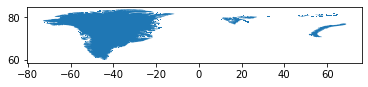

In [17]:
df.plot()

In [ ]:
df.plot('geometry')

In [ ]:
data = major.append(minor, sort=False)
data = data[['maj_bas', 'maj_name', 'maj_area', 'sub_bas', 'sub_name', 'sub_area',
       'level', 'geometry']]
data

Save `GeoDataFrame` as `GeoJSON`

In [ ]:
data.to_file("../data/mbtiles/hydrological_basins.json", driver="GeoJSON")

Save `GeoDataFrame` as `Shapefile`

In [ ]:
data.to_file("../data/mbtiles/hydrological_basins/hydrological_basins.shp")

<a id='political_boundaries'></a>
#### **Political boundaries ([source](https://gadm.org/data.html))**

**gadm36 political boundaries**

In [ ]:
account = "wri-01"
api_key = getpass.getpass('Carto account api key:')

In [ ]:
account = "wri-01"

query = "SELECT name_0, name_1, name_2, area, size, level, gid_0, gid_1, gid_2, the_geom FROM gadm36_political_boundaries"

data = long_lasting_SQL_queries(account, query, api_key)
data.head()

In [ ]:
data.plot()

In [ ]:
gadm36 = gpd.read_file('../data/mbtiles/gadm36_political_boundaries/gadm36_political_boundaries.shp')
gadm36.drop(columns='cartodb_id', inplace=True)
gadm36.head()

In [ ]:
gadm36 = gadm36[gadm36['level'].isin([0,1])]

Save `GeoDataFrame` as `GeoJSON`

In [ ]:
gadm36.to_file("../data/mbtiles/gadm36_political_boundaries.json", driver="GeoJSON")

**Disputed boundaries 2018**

In [ ]:
account = "wri-01"

query = "SELECT gid_0, name_0, name, note, the_geom FROM disputed_boundaries_2018 WHERE gid_0 in ('PAK', 'IND', 'CHN') AND name in ('Indian claim', 'Pakistani claim', 'Chinese claim')"

data = df_from_carto(account, query)
data

#### Major Physical Features ([source](file:///Users/ikersanchez/Vizzuality/GitHub/sci_team_data_bank/Projects/soils-revealed/data/mbtiles/ne_10m_geography_regions_elevation_points/ne_10m_geography_regions_elevation_points.README.html))
**Physical areas**

In [ ]:
polys = gpd.read_file('../data/mbtiles/ne_10m_geography_regions_polys/ne_10m_geography_regions_polys.shp')
polys = polys[~polys.featurecla.isin(['Island group', 'Dragons-be-here', 'Lake'])]
polys.head()

In [ ]:
polys['featurecla'].unique()

In [ ]:
polys.plot()

Save `GeoDataFrame` as `GeoJSON`

In [ ]:
polys.to_file("../data/mbtiles/ne_10m_geography_regions.json", driver="GeoJSON")

<a id='create_mbtiles_2'></a>
### Create `MBTiles`

In [ ]:
layers = {'Hydrological basins': 'hydrological_basins.json',
         'Ecoregions': 'ecoregions_by_biome.json',
         'Political boundaries': 'gadm36_political_boundaries.json',
         'Physical geography regions': 'ne_10m_geography_regions.json'}

layers = {'Political boundaries': 'gadm36_political_boundaries.json'}

for layer_name, file in layers.items():
    print(layer_name)
    source_path = "../data/mbtiles/"+file
    dest_path = "../data/mbtiles/"+file.split('.')[0]+".mbtiles"
    create_mbtiles(source_path, dest_path, layer_name, opts="-zg --drop-densest-as-needed --extend-zooms-if-still-dropping --force --read-parallel")

<a id='show_mbtiles'></a>
### Show `MBTiles` in our localhost

In [ ]:
!mbview --port 9000 ../data/mbtiles/gadm36_political_boundaries.mbtiles

<a id='serve_mbtiles'></a>
### 7. Serve `MBTiles` in our localhost

In [ ]:
!docker run --rm -p 8080:8000 -v /Users/ikersanchez/Vizzuality/GitHub/sci_team_data_bank/Projects/soils-revealed/data/mbtiles:/tilesets  consbio/mbtileserver

Paste in your browser the following:

`http://localhost:8080/services/hydrological_basins`

And to see the tiles on a map:

`http://localhost:8080/services/hydrological_basins/map`